Introduction and importing dependencies

In [2]:
!pip install --upgrade pip setuptools
!pip install tensorflow opencv-python matplotlib
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
pip install --upgrade opencv-python-headless

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [49]:
#importing tensor flow Dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten


In [6]:
#Limiting GPU Memory consumption growth so we do not run into out of memory exeption/error
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.set_memory_growth(gpu, True)

#List of All available GPUs(Currently list of GPUs is empty because my laptop does not come with any built-in GPU)
gpus

[]

In [7]:
#Defining Folder Structures
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative') 
ANC_PATH = os.path.join('data','anchor')

In [8]:
# #Creating the required directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

Unpacking Labelled Faces, Collecting Anchor/ Positive Images

In [9]:
import uuid

In [10]:
# We establish a connection to the webcam
cap = cv2.VideoCapture(0)

# Looping through every single frame in the webcam
while cap.isOpened():   
    # Return value is boolean and tells us if the video capture device is working
    # Frame returns the current frame as an image
    ret, frame = cap.read()

    frame = frame[200:200+250, 500:500+250, :]

    #Collecting Anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        #Creating unique name/filepath
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write the anchor image to the path
        cv2.imwrite(imgname, frame)
    #Collecting Positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write the anchor image to the path
        cv2.imwrite(imgname, frame)
        
    # Renders the returned frame in a window on the screen titled 'Image Captured'
    cv2.imshow('Image Captured', frame)
    
    # If the 'q' key is pressed then the system exits the current running window
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("Exiting....")
        break
    
# Release the webcam
cap.release()
# Destroy the specific window
cv2.destroyWindow('Image Captured')
# Ensure all windows are closed
cv2.destroyAllWindows()
print("Webcam released and all related windows closed")

2024-07-04 15:11:20.666 Python[1125:10157] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


Exiting....
Webcam released and all related windows closed


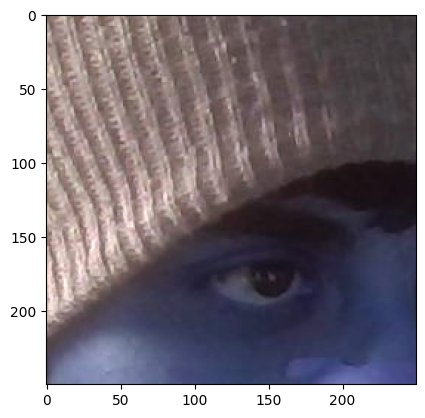

In [11]:
plt.imshow(frame)

In [12]:
#Fetching the image directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [13]:
ANC_PATH+'/*.jpg'

'data/anchor/*.jpg'

In [14]:
dir_test = anchor.as_numpy_iterator()

In [15]:
print(dir_test.next())

b'data/anchor/de86867a-1ea8-11ef-8d16-be8281faaadb.jpg'


In [16]:
#image preprocessing function
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img) #load in the image using the decode method
    #Preprocessing steps
    img = tf.image.resize(img, (100, 100))#resizing image to be 100pX100pX3channels
    img = img/255.0 #Normalization
    return img

In [17]:
img = preprocess('data/anchor/dc84ffdc-1ea8-11ef-8d16-be8281faaadb.jpg')

In [18]:
#Printing the scale of the darkest to the lightest pixel
#Usually min() = 0 because the darkest pixel is black
#max() value is the lightest pixel . Here there is no field of white so the vlaue is slightly less than 1
print(img.numpy().min())
print("to")
print(img.numpy().max())

0.0
to
0.9884804


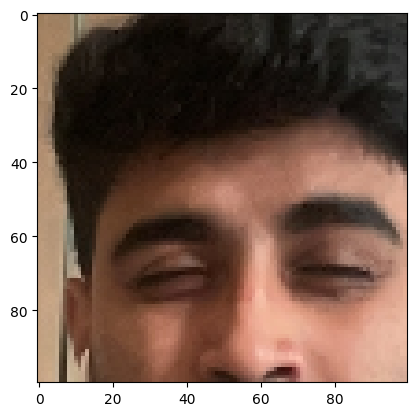

In [19]:
plt.imshow(img)

Creating Labelled Dataset

In [20]:
#(anchor, positive) => 1,1,1,1,1
#(anchor, negative) => 0,0,0,0,0

In [21]:
positives = tf.data.Dataset.zip(anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))
negatives = tf.data.Dataset.zip(anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))
data=positives.concatenate(negatives)

In [22]:
samples = data.as_numpy_iterator()

In [23]:
example = samples.next()

In [24]:
example

(b'data/anchor/44b64c1e-1e27-11ef-844f-be8281faaadb.jpg',
 b'data/positive/5d1a07ba-1ea8-11ef-8d16-be8281faaadb.jpg',
 1.0)

Train test partitioning

In [25]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [26]:
res = preprocess_twin(*example)

In [27]:
res[0]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.90563726, 0.7644608 , 0.5683824 ],
        [0.90294117, 0.7617647 , 0.55784315],
        [0.9022059 , 0.7610294 , 0.55710787],
        ...,
        [0.04632353, 0.04828431, 0.08946078],
        [0.03700981, 0.04485294, 0.09485294],
        [0.04068628, 0.04852941, 0.09950981]],

       [[0.9078431 , 0.76666665, 0.57058823],
        [0.90294117, 0.7617647 , 0.5656863 ],
        [0.9022059 , 0.7610294 , 0.5605392 ],
        ...,
        [0.05367647, 0.05563726, 0.09681372],
        [0.04117647, 0.04901961, 0.09828431],
        [0.03676471, 0.04460784, 0.09460784]],

       [[0.8879902 , 0.7468137 , 0.5448529 ],
        [0.8960784 , 0.75490195, 0.5529412 ],
        [0.89166665, 0.75710785, 0.5529412 ],
        ...,
        [0.07230392, 0.07867647, 0.1242647 ],
        [0.07279412, 0.08063725, 0.12769608],
        [0.06176471, 0.06960785, 0.11666667]],

       ...,

       [[0.8355392 , 0.6933824 , 0.49534315],
        [0.82

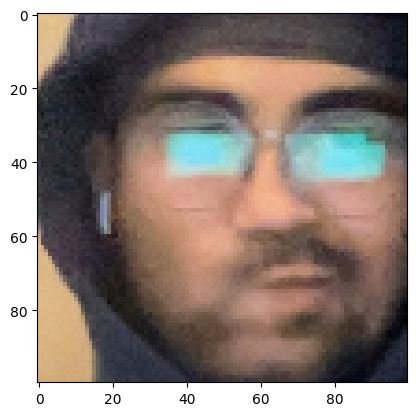

In [28]:
plt.imshow(res[0])

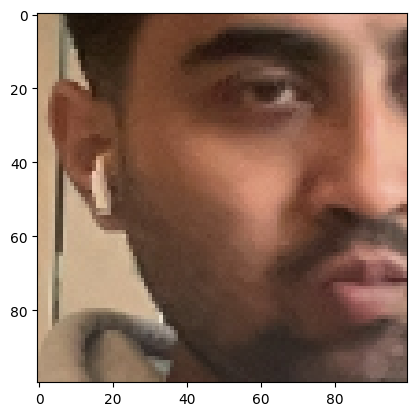

In [29]:
plt.imshow(res[1])

In [30]:
res[2]

1.0

In [31]:
#Building a data loader pipeline
data = data.map(preprocess_twin)
data = data.cache()
#Shuffling so that we do not have one type of images when we train and all the 3 classes of images appear random
data = data.shuffle(buffer_size=1024)

In [32]:
samples = data.as_numpy_iterator()

In [33]:
samp = samples.next()

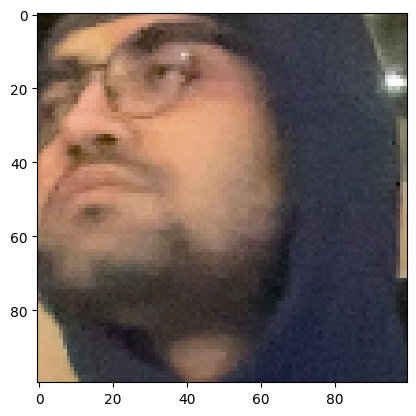

In [34]:
plt.imshow(samp[0])

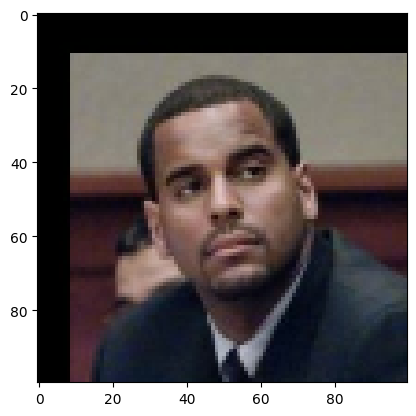

In [35]:
plt.imshow(samp[1])

In [36]:
samp[2]

0.0

In [43]:
samp1 = samples.next()

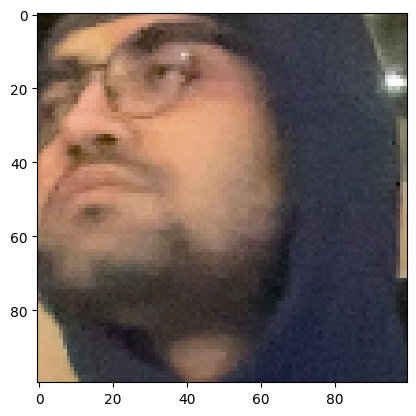

In [44]:
plt.imshow(samp[0])

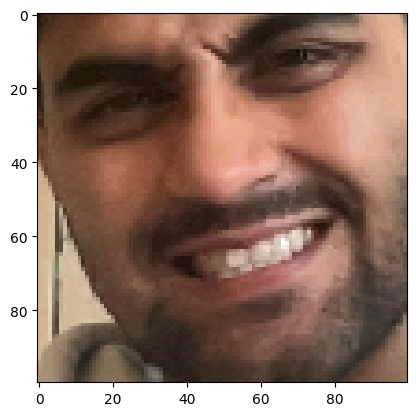

In [45]:
plt.imshow(samp1[1])

In [46]:
samp1[2]

1.0

In [47]:
#Training Partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [48]:
#Test Partition
test_data = data.skip(round(len(data)*.7))
test_data = data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

**Model Engineering**

In [84]:
inp = Input(shape=(105,105,3), name = 'input_image')

In [85]:
c1 = Conv2D(64,(10,10), activation='relu')(inp)
m1 = MaxPooling2D(64,(2,2), padding = 'same')(c1)
    
#Second set of Layers
c2 = Conv2D(128,(7,7), activation = 'relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    


In [87]:
c2

<KerasTensor shape=(None, 42, 42, 128), dtype=float32, sparse=False, name=keras_tensor_28>

In [52]:
def make_embedding():
    inp = Input(shape=(100,100,3), name = 'input_image')
    
    #First set of layers
    c1 = Conv2D(64,(10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2), padding = 'same')(c1)
    
    #Second set of Layers
    c2 = Conv2D(128,(7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    #Third set of layers
    c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding = 'same')(c3)
    
    
    
    return Model(inputs=, outputs=,name =)
    

SyntaxError: invalid syntax (3950441294.py, line 4)